In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import activations
from tensorflow.keras import layers


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import plot_model

In [3]:
import  numpy as np
import  matplotlib.pyplot as plt

class_names2 = ['cassette_player','chain_saw','church','French_horn','garbage_truck','gas_pump','golf_ball','parachute','springer','tench']
def plot(images,labels):
    fig,axes = plt.subplots(3,5,figsize=(12,6))
    axes = axes.flatten()
    for img,label ,ax in zip(images,labels,axes):
        ax.imshow(img)
        ax.set_title(class_names2[np.argmax(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [22]:
def train_generator(data_dir,target_size, batch_size, class_mode=None):
    train_datagen = ImageDataGenerator(rescale=1./255.)
    return  train_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
    )

def val_generator(data_dir,target_size, batch_size, class_mode=None):
    val_datagen = ImageDataGenerator(rescale=1./255.)
    return  val_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
    )
def test_generator(data_dir,target_size, batch_size, class_mode=None):
    test_datagen = ImageDataGenerator(rescale=1./255.)
    return  test_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

def pred_generator(data_dir,target_size, batch_size, class_mode=None):
    pred_datagen = ImageDataGenerator(rescale=1./255.)
    return pred_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )


In [29]:
train_gen = train_generator(
    data_dir='./imagenette/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 9469 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [30]:
val_gen = val_generator(
    data_dir='./imagenette/val',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
)

Found 3925 images belonging to 10 classes.


In [7]:
class ResnetBlock(Model):
    def __init__(self,filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = layers.Conv2D(filters, (3,3), strides=strides, padding='same', use_bias=False)
        self.b1 = layers.BatchNormalization()
        self.a1 = layers.Activation('relu')

        self.c2 = layers.Conv2D(filters, (3,3), strides=1, padding='same', use_bias=False)
        self.b2 = layers.BatchNormalization()

        if residual_path:
            self.down_c1 = layers.Conv2D(filters, (1,1), strides=strides, padding='same', use_bias=False)
            self.down_b1 = layers.BatchNormalization()

        self.a2 = layers.Activation('relu')

    def call(self, inputs):
        residual = inputs
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)
        return out


In [8]:
class ResNet18(Model):
    def __init__(self, block_list, initial_filters=64):
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = layers.Conv2D(self.out_filters, (3,3), strides=1, padding='same', use_bias='False',kernel_initializer='he_normal')
        self.b1 = layers.BatchNormalization()
        self.a1 = layers.Activation('relu')
        self.blocks = tf.keras.models.Sequential()

        # construct resnets

        for block_id in range(self.num_blocks):# 第几个rest net block
            for layer_id in range(block_list[block_id]): # 第几个卷积层
                if block_id != 0 and layer_id == 0: # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block) # 将构建好的block 加入resnet
            self.out_filters *= 2 # 下一个block的卷积核数量是上一个block的2倍
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x) 
        x = self.p1(x)
        y = self.f1(x)
        return y


In [31]:
    model = ResNet18([2,2,2,2])
    
 
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['sparse_categorical_accuracy'])
    checkpoint_save_path = './checkpoint/ResNet18.ckpt'
    if os.path.exists(checkpoint_save_path + '.index'):
        print(' load the model')
        model.load_weight(checkpoint_save_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                     monitor='val_sparse_categorical_accuracy',
                                                     mode='max',
                                                     save_weights_only=True,
                                                     save_best_only=True)
    #history = model.fit(train_gen, batch_size=128, epochs=20, validation_data=val_gen, callbacks=[cp_callback])
    history = model.fit(train_gen, steps_per_epoch=421, epochs=20, validation_data=val_gen, callbacks=[cp_callback])
    model.load_weights(checkpoint_save_path)

Epoch 1/20
295/295 [==============================] - 386s 1s/step - loss: 2.3445 - sparse_categorical_accuracy: 0.3063 - val_loss: 1.9605 - val_sparse_categorical_accuracy: 0.3888
Epoch 2/20
295/295 [==============================] - 384s 1s/step - loss: 1.8031 - sparse_categorical_accuracy: 0.4266 - val_loss: 1.9092 - val_sparse_categorical_accuracy: 0.4069
Epoch 3/20
295/295 [==============================] - 385s 1s/step - loss: 1.5802 - sparse_categorical_accuracy: 0.5005 - val_loss: 1.8496 - val_sparse_categorical_accuracy: 0.4301
Epoch 4/20
295/295 [==============================] - 386s 1s/step - loss: 1.4435 - sparse_categorical_accuracy: 0.5486 - val_loss: 1.5817 - val_sparse_categorical_accuracy: 0.5190
Epoch 5/20
295/295 [==============================] - 386s 1s/step - loss: 1.2689 - sparse_categorical_accuracy: 0.6031 - val_loss: 1.8431 - val_sparse_categorical_accuracy: 0.4866
Epoch 6/20
295/295 [==============================] - 386s 1s/step - loss: 1.1265 - sparse_cate

In [ ]:
model.load_weights(checkpoint_filepath)

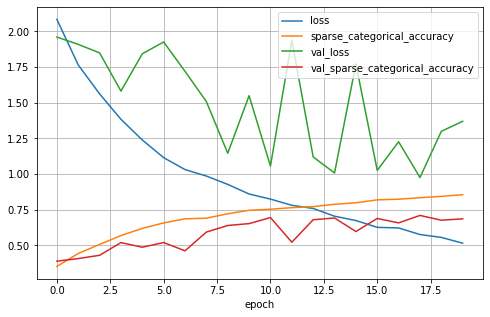

In [32]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [33]:
test_gen = test_generator(
    data_dir='./imagenette/val',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse'
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 3925 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [34]:
pred_gen = pred_generator(
    data_dir='./imagenette/val',
    target_size=(224,224),
    batch_size=32,
    class_mode=None
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 3925 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


123/123 [==============================] - 37s 296ms/step - loss: 0.9755 - sparse_categorical_accuracy: 0.7096
the loss of test set：0.9754730463027954，accuracy:0.709554135799408
result of the pred set one batch 15 pictures： [[1.83330968e-07 1.00329174e-07 8.07962442e-06 4.83647682e-06
  9.96802330e-01 5.14469502e-05 2.06394354e-04 2.88775587e-03
  1.26598352e-05 2.62513859e-05]
 [3.07481214e-02 1.76704973e-02 9.49334260e-03 7.33727574e-01
  2.94061005e-03 6.91384543e-03 1.76232494e-02 1.62675858e-01
  2.16524675e-03 1.60416104e-02]
 [9.98877466e-01 6.00832900e-05 2.21306818e-05 7.70439685e-04
  2.47476441e-06 3.48213616e-05 5.64413058e-05 3.26675909e-05
  1.39236843e-04 4.08509095e-06]
 [4.69073757e-06 8.54043947e-07 6.79312552e-06 3.59472178e-05
  9.99043524e-01 1.20131386e-04 5.29644058e-05 6.35480450e-04
  4.46157792e-05 5.49207507e-05]
 [5.68654141e-05 5.62133174e-03 7.86727786e-01 1.09005040e-02
  1.42566580e-02 1.16788801e-02 5.69724885e-04 1.53227270e-01
  8.43815506e-03 8.52277

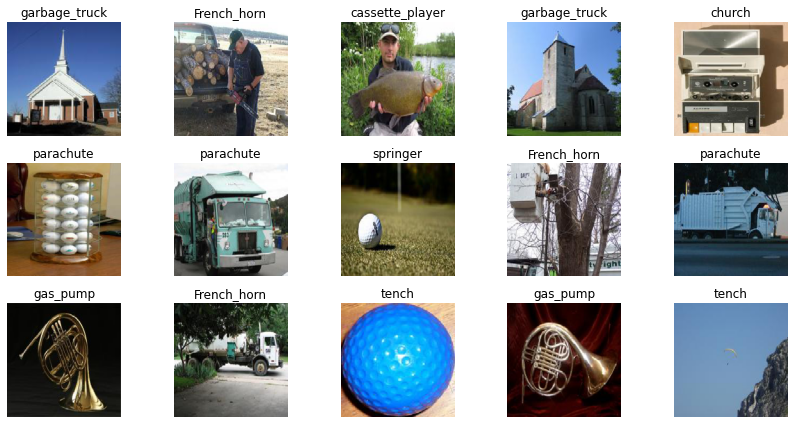

In [35]:
loss, accuracy = model.evaluate(x=test_gen)
print('the loss of test set：{0}，accuracy:{1}'.format(loss,accuracy))
#get pred set of a batch size
pred_batch = pred_gen.next()
#use the model to predict the pred set
pred_result = model.predict(x=pred_batch)
print('result of the pred set one batch 15 pictures：',pred_result)
#visualization
plot(pred_batch,pred_result)